# Мини-проект. Практика

**ПОСТАНОВКА ЗАДАЧИ**

Подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений. Наш клиент — французское рекламное агентство criteo. Оно предоставило нам данные о показах рекламы и отклике пользователей на рекламные предложения. Нужно подобрать модель для показа рекламных предложений пользователям. 

**ДАННЫЕ**

f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)

treatment: treatment group (1 = treated, 0 = control)

conversion: whether a conversion occured for this user (binary, label)

visit: whether a visit occured for this user (binary, label)

exposure: treatment effect, whether the user has been effectively exposed (binary)

<a id='0'></a> 
### ПЛАН ПРОЕКТА
<a href='#10'> **Подготовка датасета**  
<a href='#11'> **EDA**      
<a href='#1'> **Валидационный датасет**    
<a href='#12'> **Class Transformation Model**       
<a href='#2'> **S-learner и оценка качества**   
<a href='#3'> **T-learner и оценка качества**      
<a href='#4'> **X-learner и оценка качества**  
<a href='#5'> **R-learner и оценка качества**  
<a href='#6'> **UpliftRandomForest и оценка качества**  
<a href='#7'> **Выводы о лучших моделях**

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import scipy
import sklift
from scipy import stats
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
import seaborn as sns, math, os, warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

RND = 42
TST = 0.3
THREADc = 2

In [2]:
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve

from catboost import CatBoostClassifier

**ФУНКЦИИ**

In [3]:
def show_distination(_list, target):
    '''
    Изображает распределение признаков и боксплоты с выбросами по значениям целевой функции
    '''
    len_list = len(_list)
    length = 16
    if len_list<4:
        length = 4*len_list
    fig, axs = plt.subplots(2,len_list, constrained_layout=True, figsize=(length, 5))
    
    for i in range(len_list):
        
        df[_list[i]].hist(ax=axs[0,i])
        df.boxplot(column=[_list[i]], by=target, ax=axs[1,i])

In [4]:
def iqr_cut(df, y):
    
    iqr = scipy.stats.iqr(df[y])
    #print(iqr)

    del_index = df[df[y]<np.percentile(df[y],25) - 1.5*iqr].index
    df = df.loc[list(set(df.index)-set(del_index.tolist()))]

    del_index = df[df[y]>np.percentile(df[y],75) + 1.5*iqr].index
    df = df.loc[list(set(df.index)-set(del_index.tolist()))]

In [5]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)

def show_corr(df): 
    '''
    Рисует Матрицу корреляции признаков
    '''
    cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                                 hue = 0.5, as_cmap=True)

    sns.set_context(font_scale=2)

    # Pair grid set up
    g = sns.PairGrid(df)

    # Scatter plot on the upper triangle
    g.map_upper(plt.scatter, s=10, color = 'red')

    # Distribution on the diagonal
    g.map_diag(sns.distplot, kde=False, color = 'red')

    # Density Plot and Correlation coefficients on the lower triangle
    g.map_lower(sns.kdeplot, cmap = cmap)
    g.map_lower(corrfunc);

In [7]:
def print_qini(y_test, pred_uplift_ct, treat_test, text_print, perfect=False):
    '''
    Печать qini-кривой с помощью библиотеки sklift
    '''
    print(text_print)

    # AUQC = area under Qini curve = Qini coefficient
    auqc = qini_auc_score(y_test, pred_uplift_ct, treat_test) 
    print(f"Qini coefficient: {auqc:.3f}")

    auuc = uplift_auc_score(y_test, pred_uplift_ct, treat_test) 
    print(f"Uplift auc score: {auuc:.3f}")

    # qini curve
    plot_qini_curve(y_test, pred_uplift_ct, treat_test, perfect=False);
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

In [43]:
def qini_df(df):
    '''
    Реализузация подсчета qini скора
    '''
    # 1. Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    print('ord=', ranked['random_uplift'])
    return (ranked['uplift'] - ranked['random_uplift']).sum()

<a id='10'></a> 
### Подготовка датасета

<a href='#0'> *Вернуться к плану проекта*

In [9]:
path = r'F:\SkillFactory\Y2_U22_Uplift\criteo-uplift-v2.1'

df = pd.read_csv(os.path.join(path,"criteo-uplift-v2.1.csv"), sep=",")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [11]:
# Уменьшим размеры используемой памяти
for col in ['treatment', 'conversion', 'visit', 'exposure']:
    df[col] = df[col].astype('int8')
for i in range(12):
    col = 'f'+str(i)
    df[col] = df[col].astype('float16')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float16
 1   f1          float16
 2   f2          float16
 3   f3          float16
 4   f4          float16
 5   f5          float16
 6   f6          float16
 7   f7          float16
 8   f8          float16
 9   f9          float16
 10  f10         float16
 11  f11         float16
 12  treatment   int8   
 13  conversion  int8   
 14  visit       int8   
 15  exposure    int8   
dtypes: float16(12), int8(4)
memory usage: 373.3 MB


In [200]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.617,10.062,8.977,4.680,10.281,4.117,0.294,4.832,3.955,13.188,5.301,-0.169,1,0,0,0
1,12.617,10.062,9.000,4.680,10.281,4.117,0.294,4.832,3.955,13.188,5.301,-0.169,1,0,0,0
2,12.617,10.062,8.961,4.680,10.281,4.117,0.294,4.832,3.955,13.188,5.301,-0.169,1,0,0,0
3,12.617,10.062,9.000,4.680,10.281,4.117,0.294,4.832,3.955,13.188,5.301,-0.169,1,0,0,0
4,12.617,10.062,9.039,4.680,10.281,4.117,0.294,4.832,3.955,13.188,5.301,-0.169,1,0,0,0


<a id='11'></a> 
### EDA

<a href='#0'> *Вернуться к плану проекта*

Посмотрим на полный датасет, прежде всего на распределеление бинарных признаков воздействия рекламой и признаки ответа на эту обработку, отметим резкий дисбаланс классов:

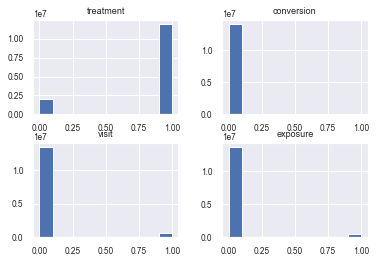

In [171]:
df[['treatment','conversion','visit','exposure']].hist();

In [10]:
df.treatment.value_counts()

1    11882655
0     2096937
Name: treatment, dtype: int64

In [11]:
df.visit.value_counts()

0    13322663
1      656929
Name: visit, dtype: int64

Поскольку признаков "ответа на воздействие" несколько, то для удобства анализа попробуем их представить в виде нескольких классов:**

In [206]:
df['class'] = (df['conversion']+(df['visit']*10)+(df['exposure']*100)+(df['treatment']*1000)).astype('int16')
df['class2'] = (df['conversion']+(df['visit']*2)+(df['exposure']*4)+(df['treatment']*8)).astype('int16')
#df['y0'] = (df['conversion']+df['visit']+df['exposure']).astype('int8')
#df['y0'] = np.where(df['y0']>0, 1, 0)

In [155]:
df['class'].value_counts()

1000    11055129
0        2016832
1010      385634
1100      250702
1110      154479
10         76042
1111       23031
1011       13680
11          4063
Name: class, dtype: int64

<AxesSubplot:>

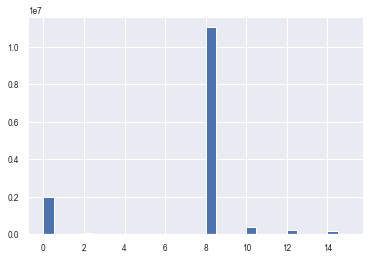

In [174]:
df['class2'].hist(bins=30)

In [159]:
df[(df.treatment == 1) & (df.visit == 0)& (df.conversion == 1)]['class'].count()

0

**Из данного представления можно сделать следующие наблюдения:**

Датасет делится на 2 группы: 11.883 тыс(treatment) - подвергшиеся воздействию(наблюдаемая группа: treatment=1) и 2.097 млн (non treatment, treatment=0) не подвергшиеся воздействию, или контрольная группа.

Если подвергшиеся воздействию объекты позволяют определить, 

сколько из них имеют эффект от воздействия: 0.428 млн против 11.454 млн;

был ли визит: 0.577 млн против 11.306 млн;

был ли последующий заказ: 0.037 млн против 11.846 млн

то для контрольной группы:

был ли визит: 0.080 млн против 2.017 млн;

был ли заказ: 0.004 млн против 2.093 млн

Заказов без визита не было.

Поскольку заказов без визита не было, но нас будет интересовать именно воздействие рекламы на совершение покупки. Поэтому выбираем только записи с совершенным визитом:

In [13]:
df = df[df['visit']==1].copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656929 entries, 715 to 13979589
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   f0          656929 non-null  float16
 1   f1          656929 non-null  float16
 2   f2          656929 non-null  float16
 3   f3          656929 non-null  float16
 4   f4          656929 non-null  float16
 5   f5          656929 non-null  float16
 6   f6          656929 non-null  float16
 7   f7          656929 non-null  float16
 8   f8          656929 non-null  float16
 9   f9          656929 non-null  float16
 10  f10         656929 non-null  float16
 11  f11         656929 non-null  float16
 12  treatment   656929 non-null  int8   
 13  conversion  656929 non-null  int8   
 14  visit       656929 non-null  int8   
 15  exposure    656929 non-null  int8   
dtypes: float16(12), int8(4)
memory usage: 22.6 MB


Распределение признаков на оставшемся датасете:

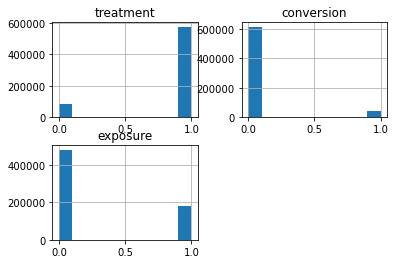

In [15]:
df[['treatment','conversion','exposure']].hist();

In [16]:
df.treatment.value_counts()

1    576824
0     80105
Name: treatment, dtype: int64

In [17]:
df.conversion.value_counts()

0    616155
1     40774
Name: conversion, dtype: int64

In [18]:
df.exposure.value_counts()

0    479419
1    177510
Name: exposure, dtype: int64

При этом признак exposure есть только у наблюдаемой группы:

In [166]:
df[(df.exposure==1)&(df.treatment==0)]['class'].count()

0

Введем target_class:

0 - Контрольная выборка, не купили товар (y=0, c в наших терминах)

1 - Контрольная выборка, купили товар (y=1, c)

2 - Выборка с воздействием (скидка), не купили товар (y=0, t)

3 - Выборка с воздействием (скидка), купили товар (y=1, t)

In [19]:
df['target_class'] = np.where((df['treatment']==0)&(df['conversion']==1),1,0)
df['target_class'] = np.where((df['treatment']==1)&(df['conversion']==0),2,df['target_class'])
df['target_class'] = np.where((df['treatment']==1)&(df['conversion']==1),3,df['target_class'])

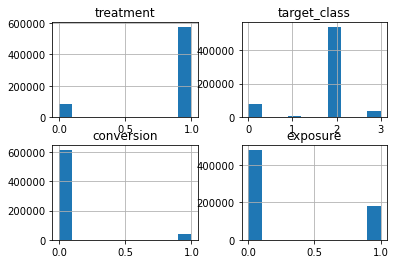

In [20]:
df[['treatment', 'target_class', 'conversion','exposure']].hist();

In [286]:
df.treatment.value_counts()

1    576824
0     80105
Name: treatment, dtype: int64

In [21]:
df.target_class.value_counts()

2    540113
0     76042
3     36711
1      4063
Name: target_class, dtype: int64

In [288]:
df.exposure.value_counts()

0    479419
1    177510
Name: exposure, dtype: int64

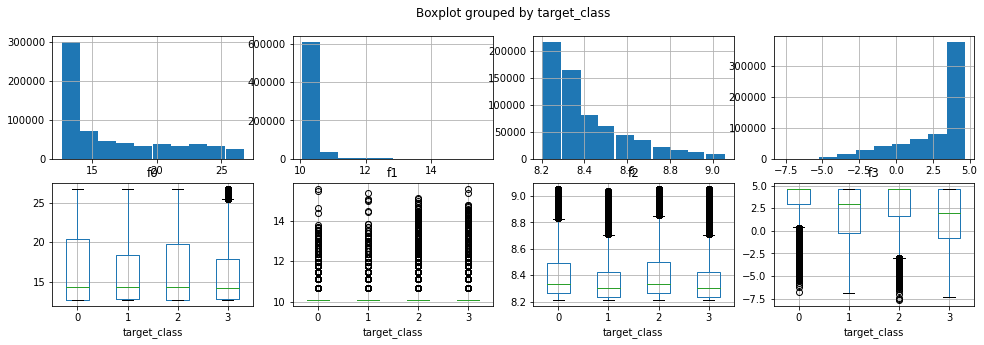

In [22]:
show_distination(['f0', 'f1', 'f2', 'f3'], 'target_class')

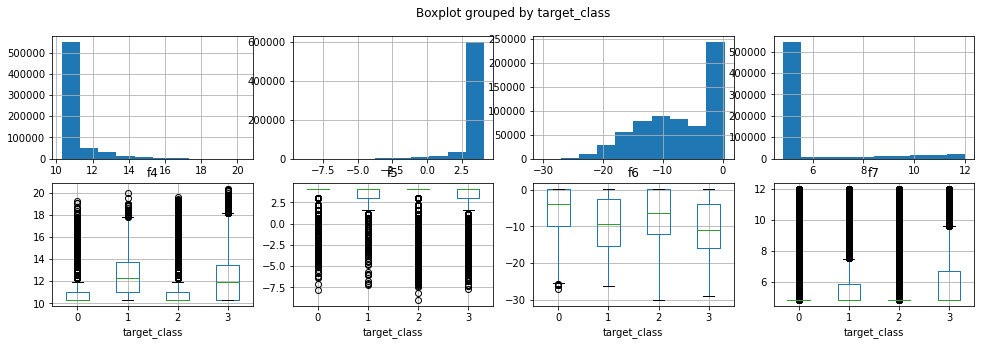

In [23]:
show_distination(['f4', 'f5', 'f6', 'f7'], 'target_class')

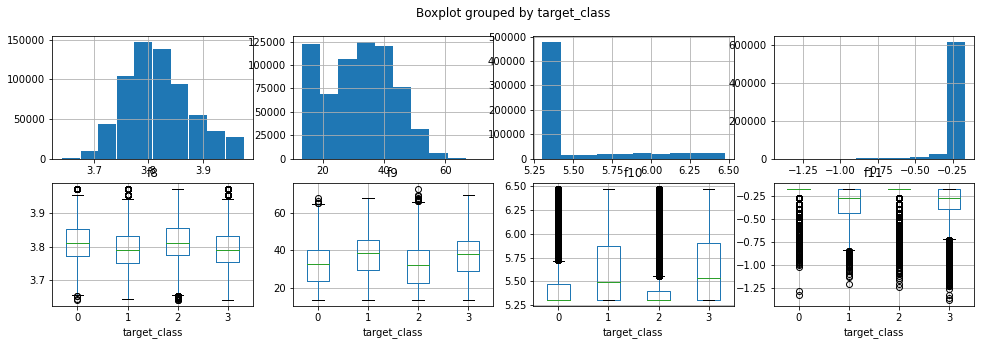

In [24]:
show_distination(['f8', 'f9', 'f10', 'f11'], 'target_class')

<AxesSubplot:>

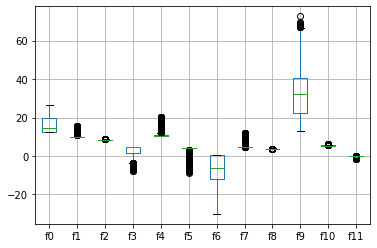

In [24]:
df.boxplot(column=['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])

In [289]:
# Убираем выбросы на основе статистик:

#cols = ['f'+str(i) for i in range(12)]
cols = ['f0','f2','f3','f4','f8','f9','f10']
for col in cols:
    y=col
    #print(df[y].describe())
    
    iqr = scipy.stats.iqr(df[y])
    print(iqr)
    median = np.median(df[y])
    #print(median)
    #del_index = df[df[y]<np.percentile(df[y],25) - 1.5*iqr].index
    #df = df.loc[list(set(df.index)-set(del_index.tolist()))]
    #df.loc[del_index][y] = median
    df[y] = np.where(df[y]<np.percentile(df[y],25) - 1.5*iqr, median, df[y])
    
    #del_index = df[df[y]>np.percentile(df[y],75) + 1.5*iqr].index
    #df = df.loc[list(set(df.index)-set(del_index.tolist()))]
    #df.loc[del_index][y] = median
    df[y] = np.where(df[y]>np.percentile(df[y],75) + 1.5*iqr, median, df[y])
    #print(df[y].describe())

7.0703125
0.234375
3.24609375
0.75
0.080078125
17.734375
0.22265625


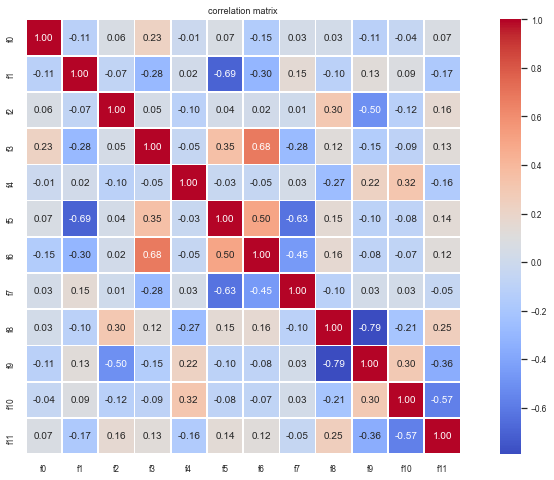

In [295]:
dfXn = df[['f' + str(i) for i in range(12)]]
# correlation of features
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("correlation matrix")
plt.show()

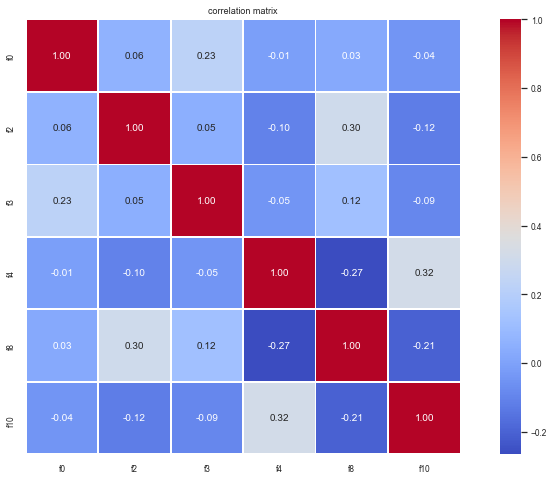

In [365]:
cols1=['f0','f2','f3','f4','f8','f10']
dfXn = df[cols1]
# correlation of features
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("correlation matrix")
plt.show()

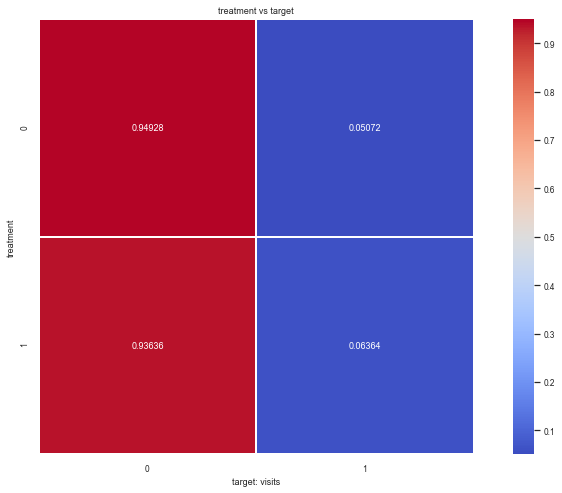

In [296]:
df['target'] = df['conversion']
# treatment vs target: visits
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
crosstab = pd.crosstab(df.treatment, df.target, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".5f", linewidths=1, square = True, cmap = "coolwarm")
plt.xlabel("target: visits")
plt.title("treatment vs target");

<a id='1'></a> 
### Валидационный датасет

<a href='#0'> *Вернуться к плану проекта*

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656929 entries, 715 to 13979589
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   f0          656929 non-null  float16
 1   f1          656929 non-null  float16
 2   f2          656929 non-null  float16
 3   f3          656929 non-null  float16
 4   f4          656929 non-null  float16
 5   f5          656929 non-null  float16
 6   f6          656929 non-null  float16
 7   f7          656929 non-null  float16
 8   f8          656929 non-null  float16
 9   f9          656929 non-null  float16
 10  f10         656929 non-null  float16
 11  f11         656929 non-null  float16
 12  treatment   656929 non-null  int8   
 13  conversion  656929 non-null  int8   
 14  visit       656929 non-null  int8   
 15  exposure    656929 non-null  int8   
 16  class       656929 non-null  int16  
 17  class2      656929 non-null  int16  
 18  exposure2   656929 non-null  int64  
 19

In [313]:
#cols = list(set(df.columns).difference({'exposure'}))
cols = ['f'+str(i) for i in range(12)] + ['treatment','conversion']
df_train, df_test = train_test_split(df[cols], stratify=df[['treatment', 'conversion']], random_state=42, test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
10531349,14.477,10.062,8.359,2.039,10.281,4.117,-8.062,4.832,3.861,22.578,5.301,-0.169,1,0
6856763,12.617,10.062,8.227,4.680,10.281,4.117,0.294,4.832,3.795,35.438,5.301,-0.169,1,0
13542067,13.922,10.062,8.680,1.614,11.031,4.117,-5.988,4.832,3.789,16.219,5.301,-0.169,1,0
10926197,17.531,10.062,8.344,2.936,10.281,4.117,-5.578,4.832,3.859,25.953,5.301,-0.169,1,0
443645,12.617,10.062,8.852,4.680,11.031,4.117,0.294,4.832,3.799,13.188,5.301,-0.169,1,0


In [314]:
cols

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'treatment',
 'conversion']

In [46]:
cols1 = ['f'+str(i) for i in range(12)]
cols = cols1 + ['treatment','conversion','target_class']
#df1 = df[cols1+['treatment', 'conversion','exposure2']].copy()
df1 = df[cols].copy()
# train/test split
#['f'+str(i) for i in range(12)]
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(df1[cols],
                            df1['treatment'], 
                            df1['conversion'],
                            stratify=df1[['treatment', 'conversion']],
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (459850, 15)
testing: (197079, 15)


In [47]:
X_train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,target_class
10531349,14.477,10.062,8.359,2.039,10.281,4.117,-8.062,4.832,3.861,22.578,5.301,-0.169,1,0,2
6856763,12.617,10.062,8.227,4.680,10.281,4.117,0.294,4.832,3.795,35.438,5.301,-0.169,1,0,2
13542067,13.922,10.062,8.680,1.614,11.031,4.117,-5.988,4.832,3.789,16.219,6.191,-0.169,1,0,2
10926197,17.531,10.062,8.344,2.936,10.281,4.117,-5.578,4.832,3.859,25.953,5.301,-0.169,1,0,2
443645,12.617,10.062,8.852,4.680,11.031,4.117,0.294,4.832,3.799,13.188,6.309,-0.169,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11211832,26.188,10.062,8.312,4.680,10.281,4.117,-3.994,4.832,3.795,41.250,5.301,-0.169,1,0,2
4133204,12.656,10.062,8.289,3.908,10.281,4.117,-1.288,4.832,3.797,45.406,5.301,-0.169,1,0,2
11114295,15.969,10.062,8.438,3.908,10.281,4.117,-1.288,4.832,3.834,27.766,5.301,-0.169,1,0,2
3248762,14.156,10.062,8.305,1.815,11.977,4.117,-7.820,4.832,3.816,37.156,5.539,-0.267,1,1,3


In [48]:
y_train

10531349    0
6856763     0
13542067    0
10926197    0
443645      0
           ..
11211832    0
4133204     0
11114295    0
3248762     1
7791548     0
Name: conversion, Length: 459850, dtype: int8

 
 <a id='12'></a> 
### Class Transformation Model

<a href='#0'> *Вернуться к плану проекта*

In [49]:
# class transformation model

ct_estimator = CatBoostClassifier(  verbose = 100, 
                                    random_state = RND,
                                    thread_count = THREADc)
model_ct = ClassTransformation(estimator = ct_estimator)
model_ct = model_ct.fit(    X = X_train[cols1], 
                            y = y_train, 
                            treatment = treat_train)

Learning rate set to 0.141212
0:	learn: 0.6200168	total: 115ms	remaining: 1m 55s
100:	learn: 0.4366252	total: 12.2s	remaining: 1m 48s
200:	learn: 0.4346212	total: 24.6s	remaining: 1m 37s
300:	learn: 0.4329873	total: 36.8s	remaining: 1m 25s
400:	learn: 0.4314412	total: 49.2s	remaining: 1m 13s
500:	learn: 0.4300370	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.4287459	total: 1m 14s	remaining: 49.8s
700:	learn: 0.4274491	total: 1m 27s	remaining: 37.1s
800:	learn: 0.4262795	total: 1m 39s	remaining: 24.6s
900:	learn: 0.4250596	total: 1m 51s	remaining: 12.2s
999:	learn: 0.4239146	total: 2m 3s	remaining: 0us


In [50]:
# model results: uplift
pred_uplift_ct = model_ct.predict(X_test[cols1])
uplift_ct_avg = weighted_average_uplift(y_test, pred_uplift_ct, treat_test, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_ct, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0155


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,17043,2665,0.333,0.259,0.074,0.004,0.008,0.009
10-20,17128,2580,0.089,0.067,0.022,0.002,0.005,0.005
20-30,17028,2680,0.035,0.024,0.011,0.001,0.003,0.003
30-40,16954,2754,0.022,0.015,0.007,0.001,0.002,0.003
40-50,16852,2856,0.019,0.013,0.006,0.001,0.002,0.002
50-60,16994,2714,0.021,0.015,0.007,0.001,0.002,0.003
60-70,17212,2496,0.025,0.021,0.004,0.001,0.003,0.003
70-80,17505,2203,0.029,0.020,0.009,0.001,0.003,0.003
80-90,17858,1850,0.034,0.022,0.012,0.001,0.003,0.004


**График uplift by percentile**

Если визуализировать таблицу, то получится график uplift by percentile. По нему удобно оценивать эффективность модели. Как его можно интерпретировать? Так как коммуникация будет проводиться с клиентами, получившими наибольшую оценку uplift, то слева на графике должны быть максимальные по модулю положительные значения uplift и в следующих перцентилях значения уменьшаются.

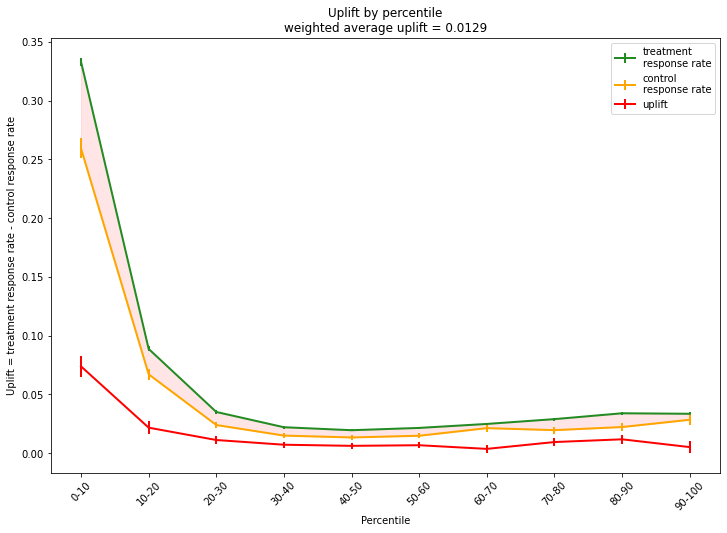

In [51]:
plot_uplift_by_percentile(y_test, pred_uplift_ct, treat_test, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

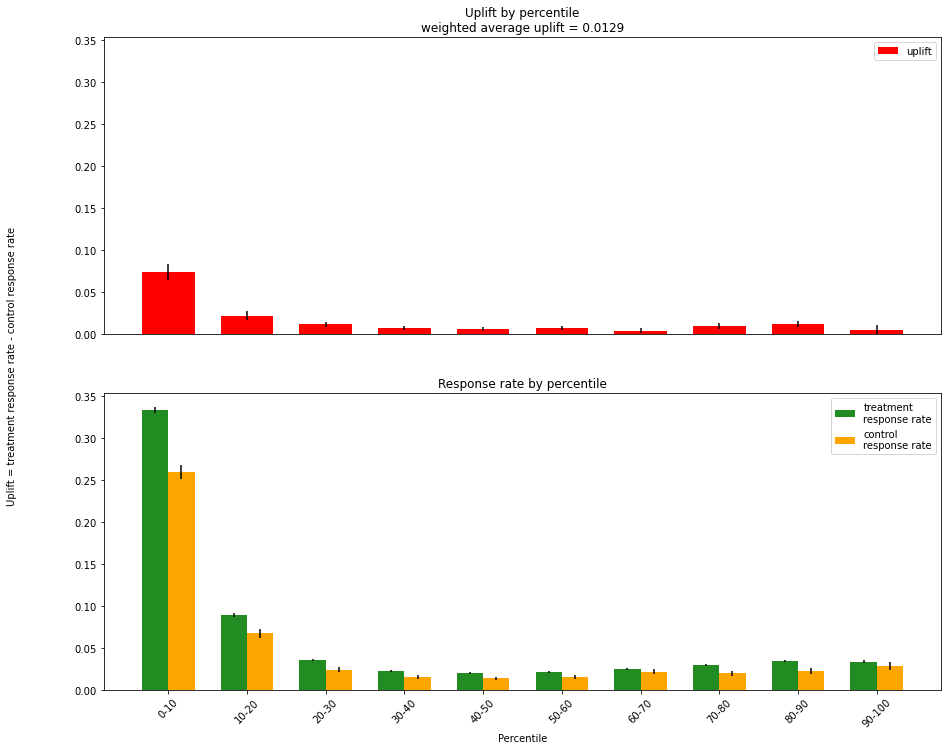

In [52]:
plot_uplift_by_percentile(y_test, pred_uplift_ct, treat_test, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)

**Qini curve**

Еще одной довольно распространенной кривой при оценке uplift моделей является Qini кривая. Qini curve, как и другие аплифт метрики, рассчитывается кумулятивно сразу для набора объектов. Кривую Qini для модели тоже сравнивают со случайной кривой (на графике желтая линия) и с идеальным случаем. Аналогично с uplift кривой, чем выше кривая над случайной кривой, тем лучше. 

Class Transformation model:
Qini coefficient: 0.085
Uplift auc score: 0.046


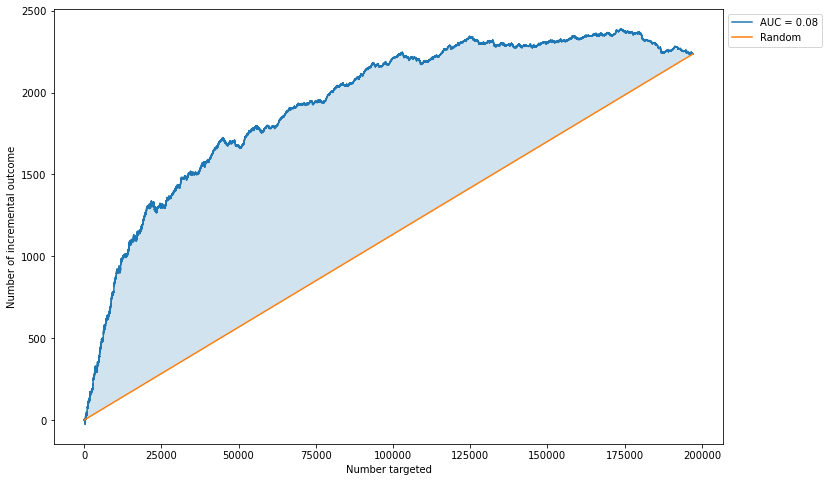

In [53]:
print_qini(y_test, pred_uplift_ct, treat_test, "Class Transformation model:", perfect=False)

In [54]:
X_test

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,target_class
2293585,20.953,10.062,8.344,4.680,11.031,4.117,-14.609,4.832,3.873,18.375,6.340,-0.169,1,0,2
9266820,12.617,10.062,8.602,4.680,10.281,4.117,0.294,4.832,3.857,34.188,5.301,-0.169,1,0,2
8702535,15.812,10.062,8.773,3.908,10.281,4.117,-7.820,4.832,3.840,13.188,5.301,-0.169,1,0,2
205901,12.617,10.062,8.430,4.680,12.594,4.117,0.294,4.832,3.775,36.656,5.996,-0.169,1,0,2
10250686,12.617,10.062,8.344,4.680,10.281,4.117,0.294,4.832,3.826,30.797,5.301,-0.169,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002845,17.000,11.117,8.492,0.720,11.031,2.230,-8.492,8.023,3.881,25.234,5.840,-0.267,1,0,2
4038569,12.617,10.062,8.281,4.680,13.062,4.117,0.294,4.832,3.783,38.906,5.395,-0.267,1,0,2
13855745,22.688,10.062,8.422,4.680,10.281,4.117,-7.820,4.832,3.826,36.344,5.301,-0.169,1,0,2
7912241,21.344,10.062,8.352,4.680,10.281,4.117,-17.297,4.832,3.852,20.047,5.301,-0.169,1,0,2


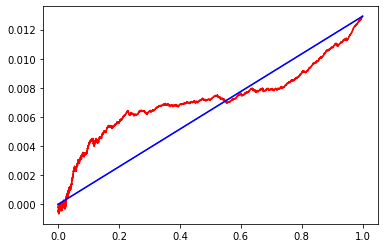

ord= 1722352    0.000
2895023    0.000
5694205    0.000
163982     0.000
1739841    0.000
            ... 
13970841   0.013
8963848    0.013
11603705   0.013
11713099   0.013
13958517   0.013
Name: random_uplift, Length: 197079, dtype: float64


134.99503999999996

In [55]:
X_test['uplift_score'] = pred_uplift_ct
qini_df(X_test)

<a id='2'></a> 
### S-learner и оценка качества

<a href='#0'> *Вернуться к плану проекта*

Модель Солоу, также известная как подход S-Learner или Treatment Dummy, основана на статье, опубликованной Дэвидом Ло в 2002 году. Он разделяет обучающий набор данных между образцами обработки и контрольными образцами. Один из его функциональных столбцов состоит из двоичных флагов обработки, 0 или 1: получил ли клиент лечение или нет.

In [425]:
#cols1 = ['f11','f4','f8','f6','f10','f0','f9']
cols1 = ['f'+str(i) for i in range(12)]
# list of feature columns: excluding the target columns
cols1 = np.setdiff1d(cols1, ['f1','f5','f7'] ).tolist()

In [426]:
cols = cols1 + ['treatment','conversion']
#df1 = df[cols1+['treatment', 'conversion','exposure2']].copy()
df1 = df[cols].copy()
# train/test split
#['f'+str(i) for i in range(12)]
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(df1[cols1],
                            df1['treatment'], 
                            df1['conversion'],
                            stratify=df1[['treatment', 'conversion']],
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (459850, 9)
testing: (197079, 9)


In [427]:
# prepare Solo Model
estimator_sm = CatBoostClassifier(  iterations = 20, 
                                    thread_count = THREADc, 
                                    random_state = RND, 
                                    silent = True)
model_sm = SoloModel(estimator_sm)
model_sm = model_sm.fit( X = X_train, 
                            y = y_train, 
                            treatment = treat_train, 
                            estimator_fit_params={'plot': True})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [428]:
# model results: uplift
pred_uplift_sm = model_sm.predict(X_test)
uplift_sm_avg = weighted_average_uplift(y_test, pred_uplift_sm, treat_test, bins=10) 
print(f"average uplift: {uplift_sm_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_sm, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0112


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,17318,2390,0.291,0.241,0.049,0.003,0.009,0.009
10-20,17626,2082,0.100,0.084,0.016,0.002,0.006,0.006
20-30,17543,2165,0.056,0.046,0.011,0.002,0.004,0.005
30-40,17487,2221,0.039,0.031,0.008,0.001,0.004,0.004
40-50,17317,2391,0.030,0.028,0.002,0.001,0.003,0.004
50-60,17217,2491,0.027,0.021,0.006,0.001,0.003,0.003
60-70,17221,2487,0.027,0.024,0.003,0.001,0.003,0.003
70-80,17299,2409,0.026,0.021,0.005,0.001,0.003,0.003
80-90,16919,2789,0.018,0.011,0.007,0.001,0.002,0.002


Средний uplift составляет 1,23%.

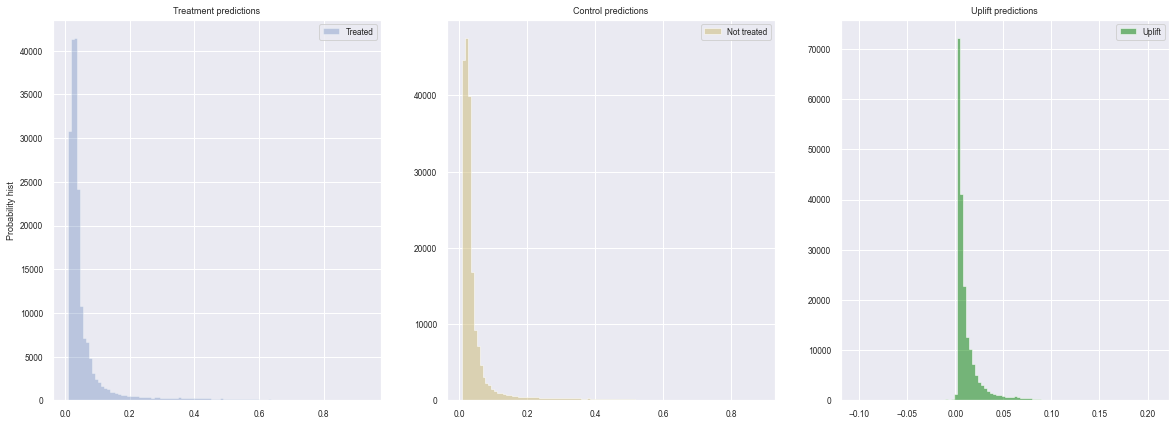

In [429]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_sm.trmnt_preds_         # probability in treatment group
prob_control = model_sm.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

S-learner:
Qini coefficient: 0.027
Uplift auc score: 0.014


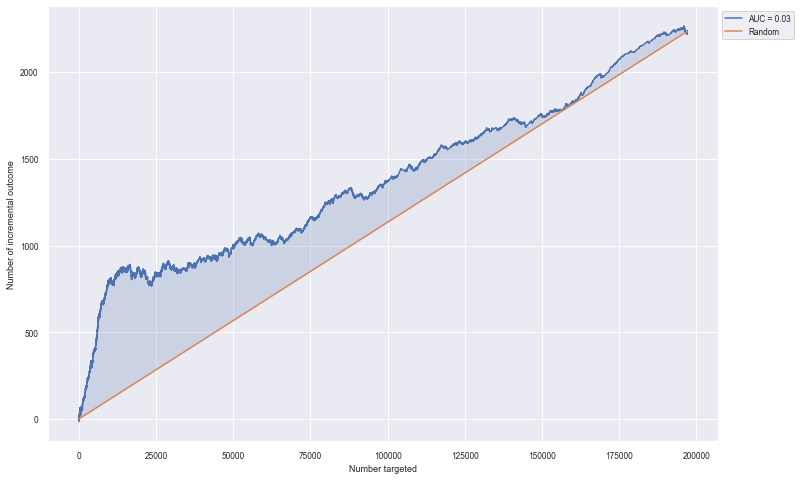

In [430]:
print_qini(y_test, pred_uplift_sm, treat_test, "S-learner:", perfect=False)

In [431]:
#feature_importances_, ранжирует объекты по их влиянию на целевую переменную

df_imp = pd.DataFrame({
            "feature_name": model_sm.estimator.feature_names_,
            "feature_importance": model_sm.estimator.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,f11,22.535
1,f8,17.619
2,f4,17.350
3,f6,9.940
4,f2,7.243
5,f0,6.708
6,f10,6.379
7,f9,5.968
8,f3,4.710
9,treatment,1.548


Мы можем использовать массивы, предоставленные функцией predict() и атрибутами trmnt_preds_ и ctrl_preds_, для сортировки наших клиентов по категориям. Сначала мы создаем новый dataframe dfZ. Его три числовых столбца состоят из оценок повышения всех клиентов и двух вероятностей, на основе которых они были рассчитаны: вероятность ответа при лечении; subtrahend: вероятность ответа при отсутствии лечения. Затем мы вставляем новый столбец — категории клиентов, “cats” — и заполняем его автоматически, оценивая три числовых столбца. В строке 9 я определяю интервалы подъема, которые будут соответствовать меткам категорий:

Подъем, близкий к нулю, подразумевает либо верные вещи, либо безнадежные дела. Используя метод вырезания pandas в строках с 9 по 11, я заключаю их в квадратные скобки в небольшом интервале между -0.01 и +0.01 и предварительно помечаю все из них как ”верные вещи".
Отрицательные подъемы ниже -0,01 указывают на спящих собак.
Те, у кого положительный подъем выше 0,01, являются убедительными.

In [432]:
# uplift by customer
dfZ = pd.DataFrame()
dfZ["prob_treat"] = model_sm.trmnt_preds_   
dfZ["prob_control"] = model_sm.ctrl_preds_   
dfZ["uplift"] = pred_uplift_sm
dfZ.sort_values("uplift", inplace=True, ascending=False)   

# classify customers by their response probabilities
cutbins = [-1, -0.01, 0.01, 1]
cutlabels = ["sleeping dog", "sure thing", "persuadable"]
dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


# sure things needs to be split between lost causes and real sure things
dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
dfZ.sort_values("uplift", ascending=False)

,prob_treat,prob_control,uplift,cats
166914,0.814,0.607,0.207,persuadable
149668,0.737,0.547,0.190,persuadable
139884,0.801,0.615,0.186,persuadable
127152,0.686,0.510,0.176,persuadable
151104,0.821,0.645,0.176,persuadable
...,...,...,...,...
131476,0.246,0.331,-0.085,sleeping dog
1890,0.379,0.469,-0.090,sleeping dog
76903,0.337,0.437,-0.100,sleeping dog
42390,0.351,0.452,-0.101,sleeping dog


В этом примере я определяю, что вероятность ниже 0,20 переводит клиента в категорию безнадежных дел. Другие клиенты, которые не меняют своего поведения после рекламной кампании, но продолжают часто взаимодействовать с веб-сайтом, помечаются как "верные вещи". Конечно, мы могли бы отделить тех, кто никогда не берет, от тех, кто всегда берет, используя другие критерии, кроме их склонности посещать веб-сайт. Маркетологи должны были бы разработать критерий, который они считают полезной информацией.

<AxesSubplot:>

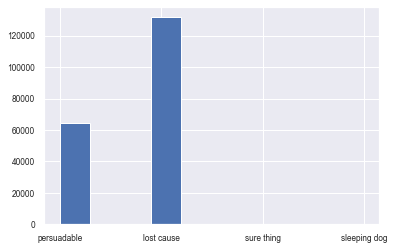

In [433]:
dfZ.cats.hist()

In [434]:
# uplift by customer category
pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")

,prob_control,prob_treat,uplift
cats,,,
sleeping dog,0.065,0.053,-0.011
sure thing,0.306,0.310,0.001
persuadable,0.055,0.074,0.019
lost cause,0.020,0.025,0.004


Когда мы рассматриваем категории клиентов, мы замечаем, что для sleeping dogs характерно отрицательное медианное повышение -1,4%; для убедительных - положительное медианное значение 2,0%. Верные вещи и безнадежные дела колеблются вокруг нуля. 

In [435]:
dfZ.groupby("cats")["uplift"].describe().T

cats,sleeping dog,sure thing,persuadable,lost cause
count,333.000,358.000,"64,655.000","131,733.000"
mean,-0.015,0.002,0.026,0.005
std,0.013,0.005,0.019,0.002
min,-0.104,-0.010,0.010,-0.010
25%,-0.013,-0.001,0.013,0.003
50%,-0.011,0.001,0.019,0.004
75%,-0.011,0.007,0.031,0.006
max,-0.010,0.010,0.207,0.010


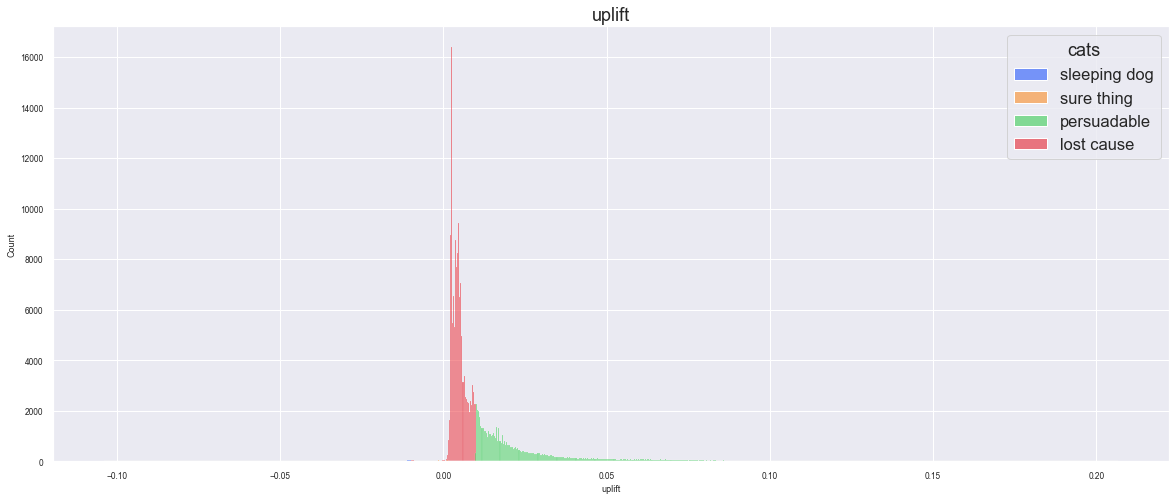

In [436]:
# uplift by category
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
    ax.set_title('uplift');

In [437]:
# classify customers by their response probabilities
cutbins = [-1, -0.01, 0.01, 0.08, 1]
cutlabels = ["sleeping dog", "sure thing", "persuadable", "avid persuadables"]
dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)

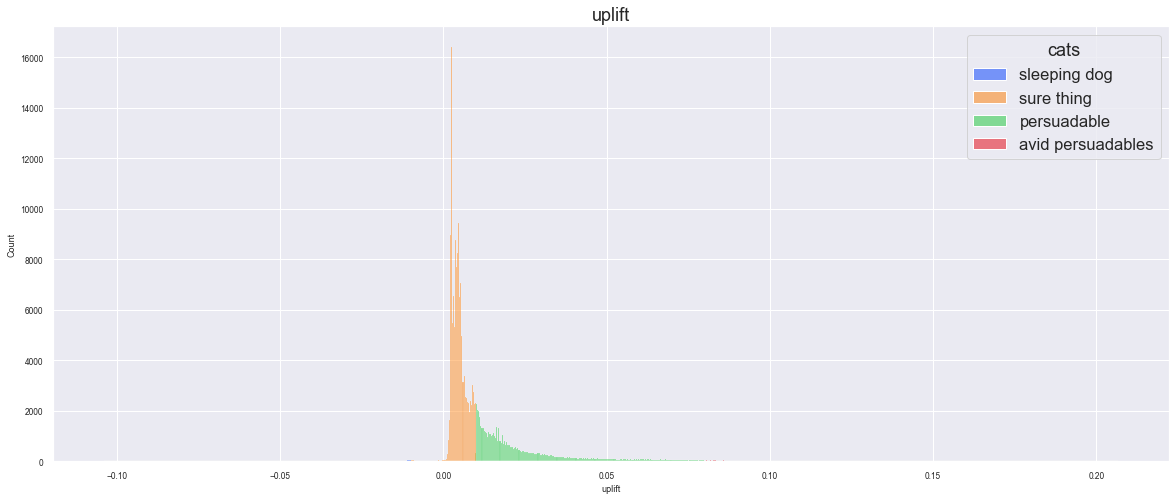

In [438]:
fig, ax = plt.subplots(figsize=(20, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
    ax.set_title('uplift');

<a id='3'></a> 
### T-learner и оценка качества

<a href='#0'> *Вернуться к плану проекта*

In [403]:
#cols1 = ['f11','f4','f8','f6','f10','f0','f9']
cols1 = ['f'+str(i) for i in range(12)]
# list of feature columns: excluding the target columns
cols1 = np.setdiff1d(cols1, ['f1', 'f5'] ).tolist()

In [404]:
cols1

['f0', 'f10', 'f11', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9']

In [405]:
cols = cols1 + ['treatment','conversion']
#df1 = df[cols1+['treatment', 'conversion','exposure2']].copy()
df1 = df[cols].copy()
# train/test split
#['f'+str(i) for i in range(12)]
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(df1[cols1],
                            df1['treatment'], 
                            df1['conversion'],
                            stratify=df1[['treatment', 'conversion']],
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (459850, 10)
testing: (197079, 10)


In [59]:
# prepare model
estimator_2m_treat = CatBoostClassifier(    iterations = 20, 
                                            thread_count = THREADc, 
                                            random_state = RND, 
                                            silent = True)

estimator_2m_control = CatBoostClassifier(  iterations = 20, 
                                            thread_count = THREADc, 
                                            random_state = RND, 
                                            silent = True)

model_2im = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                        estimator_ctrl = estimator_2m_control, 
                        method = "vanilla")
model_2im = model_2im.fit(  X_train, 
                            y_train, 
                            treat_train)

In [407]:
# model results: uplift
pred_uplift_2im = model_2im.predict(X_test)
uplift_2im_avg = weighted_average_uplift(y_test, pred_uplift_2im, treat_test, bins=10) 
print(f"average uplift: {uplift_2im_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2im, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0100


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,17341,2367,0.243,0.197,0.045,0.003,0.008,0.009
10-20,17451,2257,0.077,0.062,0.015,0.002,0.005,0.005
20-30,17589,2119,0.048,0.037,0.010,0.002,0.004,0.004
30-40,17464,2244,0.036,0.028,0.009,0.001,0.003,0.004
40-50,17274,2434,0.029,0.024,0.006,0.001,0.003,0.003
50-60,17226,2482,0.030,0.020,0.010,0.001,0.003,0.003
60-70,17058,2650,0.025,0.022,0.004,0.001,0.003,0.003
70-80,16986,2722,0.021,0.014,0.006,0.001,0.002,0.003
80-90,16909,2799,0.025,0.017,0.008,0.001,0.002,0.003


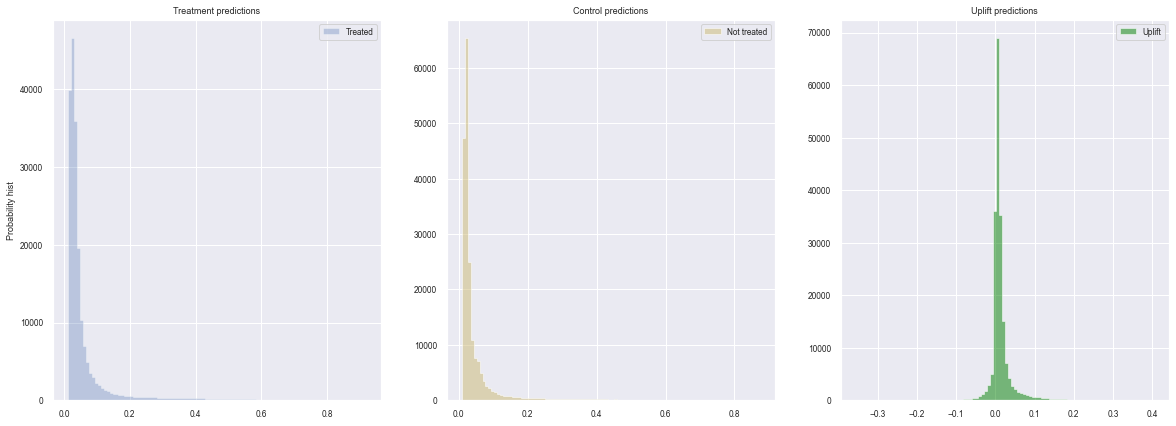

In [408]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_2im.trmnt_preds_         # probability in treatment group
prob_control = model_2im.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [409]:
df_imp = pd.DataFrame({
            "feature_name": model_2im.estimator_trmnt.feature_names_,
            "feature_importance": model_2im.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,f11,25.343
1,f8,16.948
2,f4,16.534
3,f6,10.969
4,f0,7.134
5,f9,6.780
6,f10,6.012
7,f2,5.703
8,f3,3.018
9,f7,1.558


S-learner:
Qini coefficient: 0.033
Uplift auc score: 0.017


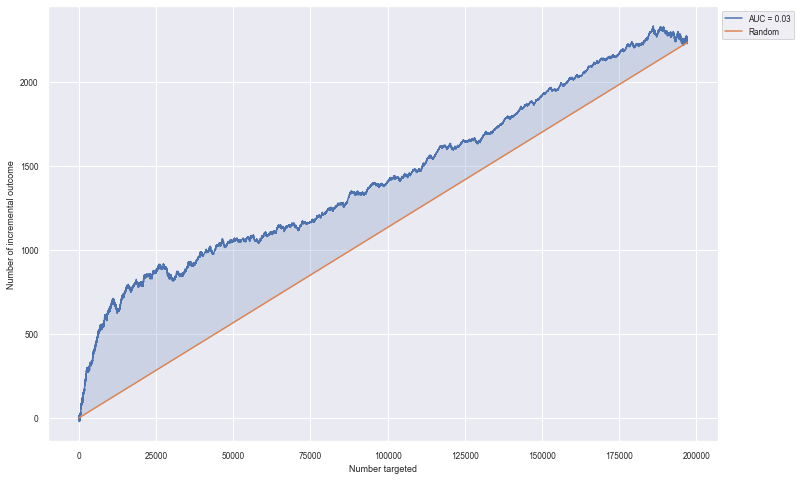

In [410]:
print_qini(y_test, pred_uplift_2im, treat_test, "T-learner:", perfect=False)

<a id='4'></a> 
### X-learner и оценка качества

<a href='#0'> *Вернуться к плану проекта*

In [460]:
#cols1 = ['f11','f4','f8','f6','f10','f0','f9']
cols1 = ['f'+str(i) for i in range(12)]
# list of feature columns: excluding the target columns
#cols1 = np.setdiff1d(cols1, ['f1'] ).tolist()

In [461]:
cols = cols1 + ['treatment','conversion']
#df1 = df[cols1+['treatment', 'conversion','exposure2']].copy()
df1 = df[cols].copy()
# train/test split
#['f'+str(i) for i in range(12)]
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(df1[cols1],
                            df1['treatment'], 
                            df1['conversion'],
                            stratify=df1[['treatment', 'conversion']],
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (459850, 12)
testing: (197079, 12)


In [462]:
# prepare model
model_2dm = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                        estimator_ctrl = estimator_2m_control, 
                        method = "ddr_control")                    # or: "ddr_treatment"


model_2dm = model_2dm.fit(  X_train, 
                            y_train, 
                            treat_train)

In [463]:
# model results: uplift
pred_uplift_2dm = model_2dm.predict(X_test)
uplift_2dm_avg = weighted_average_uplift(y_test, pred_uplift_2dm, treat_test, bins=10) 
print(f"average uplift: {uplift_2dm_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2dm, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0116


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,17286,2422,0.245,0.205,0.040,0.003,0.008,0.009
10-20,17580,2128,0.086,0.067,0.019,0.002,0.005,0.006
20-30,17490,2218,0.055,0.045,0.010,0.002,0.004,0.005
30-40,17453,2255,0.041,0.027,0.014,0.002,0.003,0.004
40-50,17423,2285,0.034,0.028,0.006,0.001,0.003,0.004
50-60,17397,2311,0.030,0.028,0.002,0.001,0.003,0.004
60-70,17155,2553,0.024,0.021,0.003,0.001,0.003,0.003
70-80,16952,2756,0.021,0.013,0.008,0.001,0.002,0.002
80-90,16893,2815,0.018,0.014,0.004,0.001,0.002,0.002


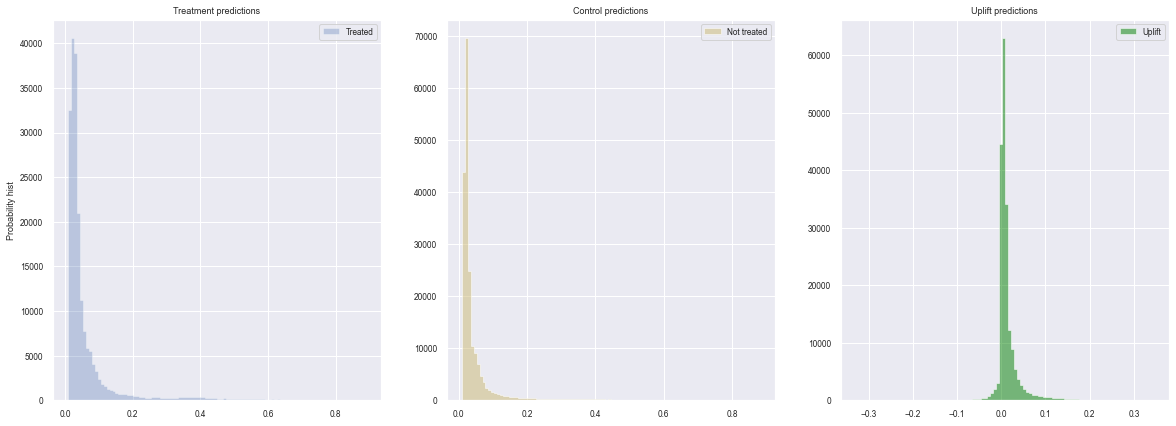

In [464]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_2dm.trmnt_preds_         # probability in treatment group
prob_control = model_2dm.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [465]:
df_imp = pd.DataFrame({
            "feature_name": model_2dm.estimator_trmnt.feature_names_,
            "feature_importance": model_2dm.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,ddr_control,46.199
1,f8,12.405
2,f9,9.298
3,f4,7.485
4,f0,7.326
5,f11,4.661
6,f6,4.363
7,f10,2.957
8,f2,2.326
9,f3,2.216


X-learner:
Qini coefficient: 0.023
Uplift auc score: 0.012


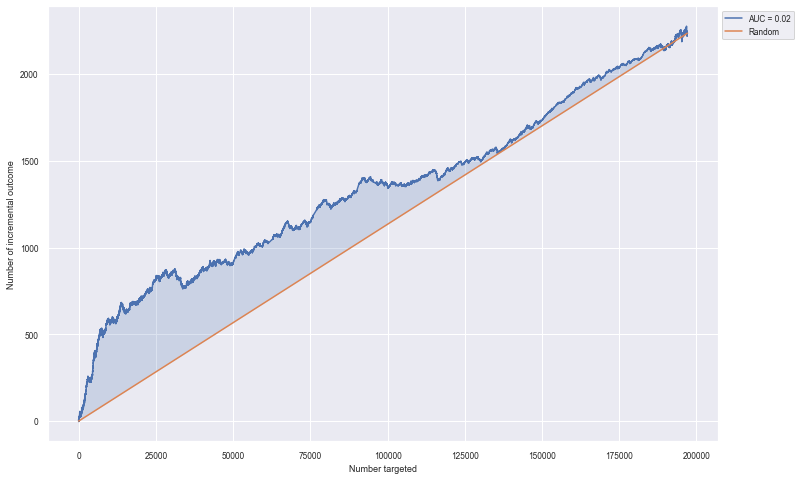

In [466]:
print_qini(y_test, pred_uplift_2dm, treat_test, "X-learner:", perfect=False)

<a id='5'></a> 
### R-learner и оценка качества

<a href='#0'> *Вернуться к плану проекта*

In [56]:
#cols1 = ['f11','f4','f8','f6','f10','f0','f9']
cols1 = ['f'+str(i) for i in range(12)]
# list of feature columns: excluding the target columns
cols1 = np.setdiff1d(cols1, ['f1'] ).tolist()

In [57]:
cols = cols1 + ['treatment','conversion']
#df1 = df[cols1+['treatment', 'conversion','exposure2']].copy()
df1 = df[cols].copy()
# train/test split
#['f'+str(i) for i in range(12)]
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(df1[cols1],
                            df1['treatment'], 
                            df1['conversion'],
                            stratify=df1[['treatment', 'conversion']],
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (459850, 11)
testing: (197079, 11)


In [60]:
# prepare model
model_2dmt = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                         estimator_ctrl = estimator_2m_control, 
                         method = "ddr_treatment")                    


model_2dmt = model_2dmt.fit(  X_train, 
                              y_train, 
                              treat_train)

In [61]:
# model results: uplift
pred_uplift_2dmt = model_2dmt.predict(X_test)
uplift_2dmt_avg = weighted_average_uplift(y_test, pred_uplift_2dmt, treat_test, bins=10) 
print(f"average uplift: {uplift_2dmt_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2dmt, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0103


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,17353,2355,0.248,0.206,0.042,0.003,0.008,0.009
10-20,17407,2301,0.083,0.070,0.013,0.002,0.005,0.006
20-30,17481,2227,0.038,0.032,0.006,0.001,0.004,0.004
30-40,17404,2304,0.029,0.020,0.009,0.001,0.003,0.003
40-50,17301,2407,0.024,0.018,0.006,0.001,0.003,0.003
50-60,17118,2590,0.023,0.013,0.010,0.001,0.002,0.003
60-70,17173,2535,0.021,0.015,0.007,0.001,0.002,0.003
70-80,17065,2643,0.022,0.018,0.004,0.001,0.003,0.003
80-90,17043,2665,0.024,0.023,0.001,0.001,0.003,0.003


R-learner:
Qini coefficient: 0.021
Uplift auc score: 0.011


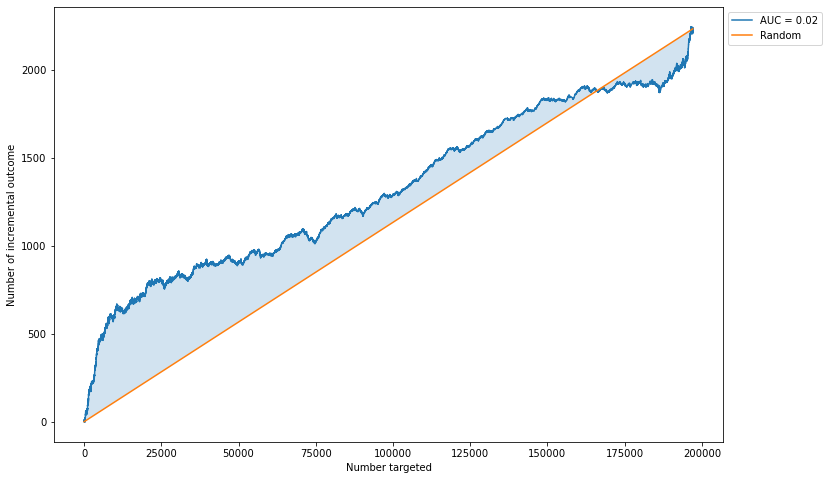

In [62]:
print_qini(y_test, pred_uplift_2dmt, treat_test, "R-learner:", perfect=False)

In [476]:
df_imp = pd.DataFrame({
            "feature_name": model_2dmt.estimator_trmnt.feature_names_,
            "feature_importance": model_2dmt.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,f11,22.647
1,f8,16.184
2,f4,15.115
3,f6,9.477
4,f0,8.646
5,f9,7.544
6,f2,6.975
7,f10,6.583
8,f3,4.270
9,f5,1.549


<a id='6'></a> 
### UpliftRandomForest и оценка качества

<a href='#0'> *Вернуться к плану проекта*

см https://drive.google.com/file/d/1IoSYarNNE7h4c1Z1HfSSEGuBsQ_BV3Vq/view?usp=sharing

<a id='7'></a> 
### Выводы о лучших моделях

<a href='#0'> *Вернуться к плану проекта*

Class Transformation model:
Qini coefficient: 0.085
Uplift auc score: 0.046


S-learner:
Qini coefficient: 0.027
Uplift auc score: 0.014


T-learner:
Qini coefficient: 0.033
Uplift auc score: 0.017


X-learner:
Qini coefficient: 0.023
Uplift auc score: 0.012


R-learner:
Qini coefficient: 0.021
Uplift auc score: 0.011


**При подготовке проекта использованы материалы статьи https://towardsdatascience.com/swaying-the-persuadables-predict-marketing-uplift-in-python-c5e9fd855b80**